<a href="https://colab.research.google.com/github/aryakulkarni05/text-classification-from-scratch/blob/main/Text_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required libraries and packages are imported.

In [ ]:
# Import necessary libraries at the beginning
import os
import pandas as pd
import re
from google.colab import drive
import nltk
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Install necessary packages
!pip install transformers torch seaborn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Extracts files from dataset, extracts transcripts from videos. Cleans the text by removing stopwords, punctuation marks, non alpha-numeric data and converts text into lowercase, deletes unwanted data also.

In [ ]:
#Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer and get the list of stopwords
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

# Enhanced text cleaning function
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Remove non-alphanumeric characters
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Remove stopwords and lemmatize each token
    cleaned_text = ' '.join(cleaned_tokens)  # Join tokens back into a single string
    return cleaned_text

# Mount Google Drive
drive.mount('/content/drive')

# Path to the IEMOCAP dataset directory
dataset_path = "/content/drive/MyDrive/Text Classification Project/IEMOCAP_full_release"

# Lists to store data
texts = []
labels = []

# Iterate over the dataset files
for session in range(1, 6):
    session_path = os.path.join(dataset_path, f'Session{session}', 'dialog', 'transcriptions')
    for root, _, files in os.walk(session_path):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    for line in f:
                        parts = line.strip().split(' ')
                        label = parts[0]
                        text = ' '.join(parts[1:])
                        texts.append(clean_text(text))
                        labels.append(label)

# Create a DataFrame with cleaned texts
df = pd.DataFrame({'text': texts, 'label': labels})

# Save the cleaned DataFrame to a CSV file
csv_file_path = "iemocap_dataset.csv"
df.to_csv(csv_file_path, index=False)

# Further cleaning of the text
def remove_leading_numbers(text):
    if isinstance(text, str):
        return re.sub(r'^\d+\s*', '', text)
    else:
        return text

df = pd.read_csv(csv_file_path)
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(remove_leading_numbers)
df.to_csv('cleaned_file.csv', index=False)
print("Numbers removed and new CSV file saved as 'cleaned_file.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Numbers removed and new CSV file saved as 'cleaned_file.csv'.


Getting a pretrained model for label analysis using transformors

Adding labels to dataset: In this dataset is given in some chunks so that it'll add labels quickly and Output files are created for each chunk/file.

In [ ]:
# Load pre-trained model and tokenizer
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

data = pd.read_csv('/content/clean_text_05.txt', delimiter=',', names=['text'])

def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return torch.argmax(probs, dim=-1).item()

data['label'] = data['text'].apply(classify_text)

label_map = {0: 'neutral', 1: 'surprise', 2: 'sadness', 3: 'joy', 4: 'disgust', 5: 'anger', 6: 'fear'}
data['label'] = data['label'].map(label_map)

data.to_csv('sentiment_05.txt', index=False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Distilbert-dataset.csv is the file created by adding all labeled subfiles together

Plotting the labeled-dataset.csv

label
surprise    4638
joy         4220
neutral      842
disgust      324
sadness      142
anger         62
label          4
Name: count, dtype: int64


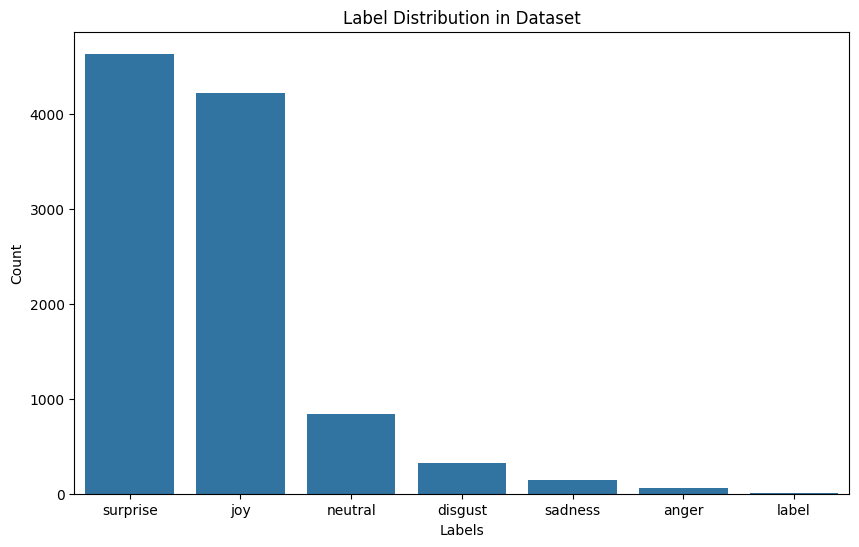

In [ ]:
data = pd.read_csv('/content/Distilbert-dataset.csv')
label_counts = data['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data, order=label_counts.index)
plt.title('Label Distribution in Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Label is extra added somehow on x-axis which will be removed further which is of no use.

Tokenized text data and converted it into sequences and saved in preprocessed_data.csv file

In [ ]:
data = pd.read_csv('/content/Distilbert-dataset.csv')
valid_labels = ['neutral', 'surprise', 'sadness', 'joy', 'disgust', 'anger', 'fear']
data = data.dropna(subset=['label'])
data = data[data['label'].isin(valid_labels)]

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])

sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, padding='post')

label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['label'])

padded_df = pd.DataFrame(padded_sequences)
combined_df = pd.concat([padded_df, pd.Series(label_encoded, name='label')], axis=1)

combined_df.to_csv('/content/preprocessed_data.csv', index=False)
print("Preprocessed data saved to 'preprocessed_data.csv'.")


Preprocessed data saved to 'preprocessed_data.csv'.


Data splitting

In [ ]:
data = pd.read_csv('/content/preprocessed_data.csv')
X = data.drop(columns=['label']).values
y = data['label'].values

num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


# Print the shapes of the resulting datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (8182, 100), (8182, 6)
Validation set: (1023, 100), (1023, 6)
Test set: (1023, 100), (1023, 6)


Defined CNN model with following layers and compiled it

In [ ]:
# Define the CNN model
vocab_size = 10000  # Should be the same as used in the tokenizer
embedding_dim = 128
max_length = X_train.shape[1]  # The maximum length of sequences

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),  # Add dropout after the pooling layer
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add another dropout layer before the output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Training of model using train , validation data

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
256/256 [==============================] - 18s 65ms/step - loss: 1.1469 - accuracy: 0.5310 - val_loss: 0.8332 - val_accuracy: 0.7126
Epoch 2/10
256/256 [==============================] - 16s 61ms/step - loss: 0.7374 - accuracy: 0.7513 - val_loss: 0.6033 - val_accuracy: 0.7869
Epoch 3/10
256/256 [==============================] - 16s 64ms/step - loss: 0.5128 - accuracy: 0.8315 - val_loss: 0.5411 - val_accuracy: 0.8084
Epoch 4/10
256/256 [==============================] - 16s 62ms/step - loss: 0.3847 - accuracy: 0.8753 - val_loss: 0.5276 - val_accuracy: 0.8348
Epoch 5/10
256/256 [==============================] - 16s 63ms/step - loss: 0.2979 - accuracy: 0.9014 - val_loss: 0.5526 - val_accuracy: 0.8328
Epoch 6/10
256/256 [==============================] - 16s 63ms/step - loss: 0.2308 - accuracy: 0.9264 - val_loss: 0.5225 - val_accuracy: 0.8534
Epoch 7/10
256/256 [==============================] - 16s 62ms/step - loss: 0.1895 - accuracy: 0.9380 - val_loss: 0.6070 - val_accuracy:

Plotting model performance

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

32/32 [==============================] - 0s 12ms/step - loss: 0.7718 - accuracy: 0.8377
Test Accuracy: 0.8377321362495422


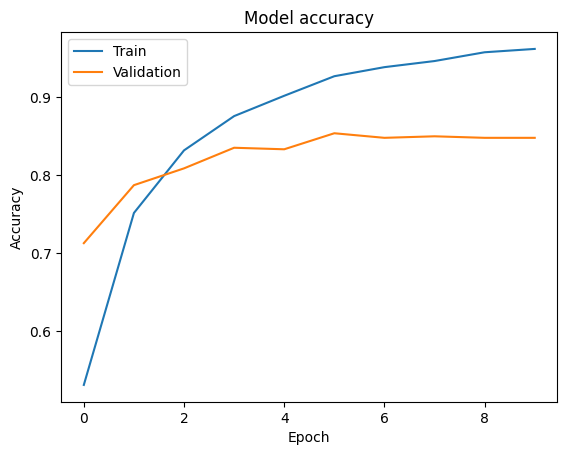

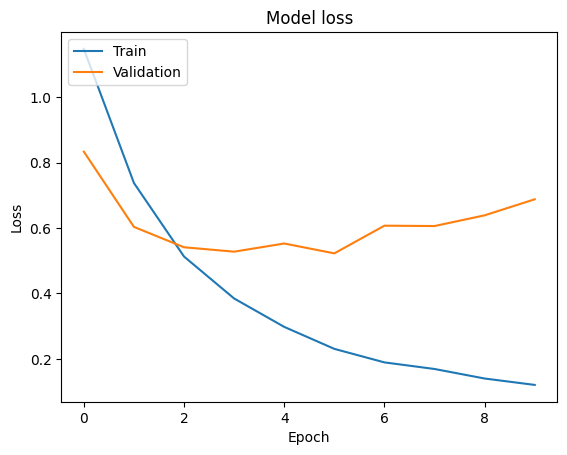

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

32/32 [==============================] - 1s 25ms/step


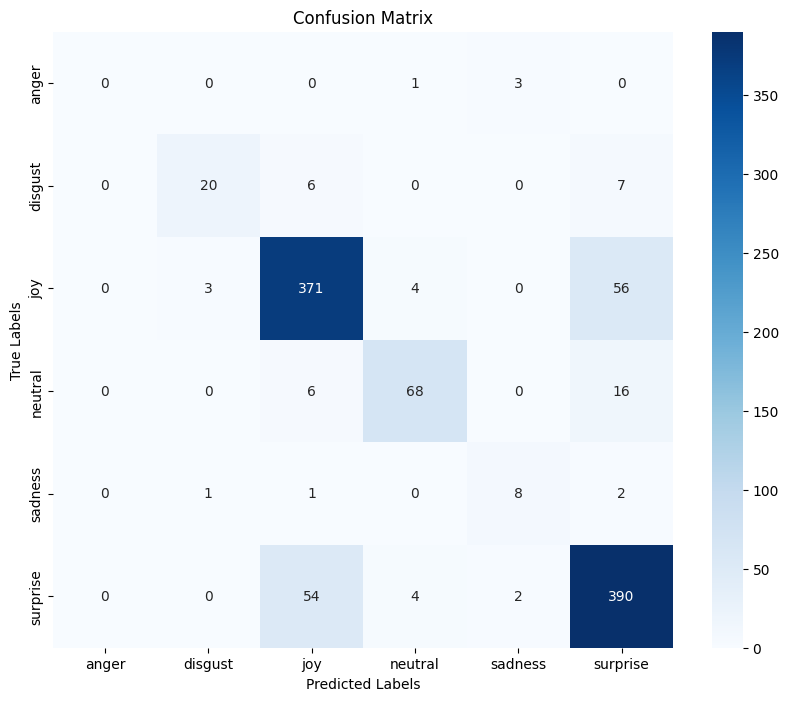

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
     disgust       0.83      0.61      0.70        33
         joy       0.85      0.85      0.85       434
     neutral       0.88      0.76      0.81        90
     sadness       0.62      0.67      0.64        12
    surprise       0.83      0.87      0.85       450

    accuracy                           0.84      1023
   macro avg       0.67      0.62      0.64      1023
weighted avg       0.84      0.84      0.84      1023



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
